# Import necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plots show in the notebook
%matplotlib inline

# Optional: Make plots look cleaner
sns.set(style="whitegrid")


Matplotlib is building the font cache; this may take a moment.


# Simulate the dataset
### We're going to simulate 1000 payment records using random values with realistic structure.

In [3]:
# Set a seed for reproducibility
np.random.seed(42)

# Generate fake payment data
data = pd.DataFrame({
    "agency": np.random.choice(["Health", "Education", "Defence", "Infrastructure"], 1000),
    "recipient_type": np.random.choice(["Company", "Non-profit", "Individual"], 1000),
    "amount": np.random.gamma(shape=2.0, scale=10000.0, size=1000),  # Skewed spending
    "payment_date": pd.date_range(start="2022-01-01", periods=1000, freq='D')
})

# Preview the data

In [4]:
data.head()

,agency,recipient_type,amount,payment_date
0,Defence,Non-profit,31341.939211,2022-01-01
1,Infrastructure,Individual,17134.371308,2022-01-02
2,Health,Company,35361.893976,2022-01-03
3,Defence,Company,18437.334811,2022-01-04
4,Defence,Company,12244.414002,2022-01-05


# Describe numeric stats

In [5]:
data["amount"].describe()


count      1000.000000
mean      20197.375625
std       14111.795410
min         244.465069
25%        9977.693102
50%       17474.048760
75%       27332.481500
max      114792.358354
Name: amount, dtype: float64

# Quick visual to see skewed distribution

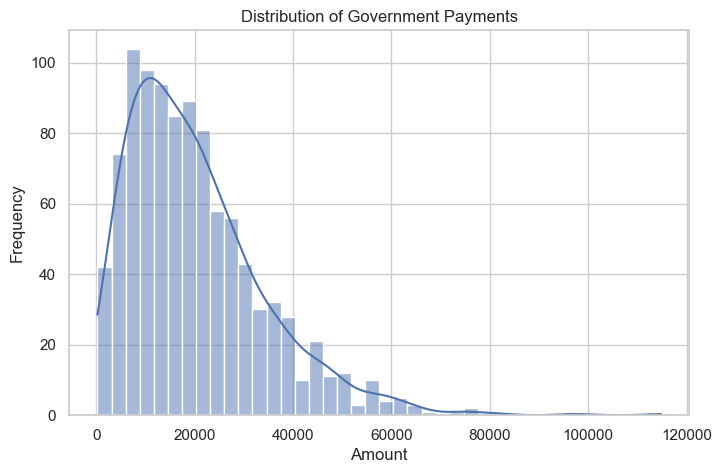

In [6]:
plt.figure(figsize=(8, 5))
sns.histplot(data["amount"], kde=True, bins=40)
plt.title("Distribution of Government Payments")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()


# One-Hot Encode Categorical Columns
### We're going to convert agency and recipient_type into machine-readable format using pd.get_dummies().

In [8]:
# Encode categorical variables
data_encoded = pd.get_dummies(data, columns=["agency", "recipient_type"], drop_first=True) # drop_first=True prevents multicollinearity by dropping one dummy variable per category.


# Extract Features from Dates
### Let’s pull out month and day of the week from payment_date.

In [9]:
# These temporal features often reveal spending cycles or suspicious weekend spikes.
data_encoded["month"] = data["payment_date"].dt.month
data_encoded["day_of_week"] = data["payment_date"].dt.dayofweek

# Drop the Original Date Column

In [13]:
# It’s no longer useful in raw form.
data.drop(columns=["payment_date"], inplace=True)

# Preview the Processed Data

In [14]:
data_encoded.head()

,amount,agency_Education,agency_Health,agency_Infrastructure,recipient_type_Individual,recipient_type_Non-profit,month,day_of_week
0,31341.939211,False,False,False,False,True,1,5
1,17134.371308,False,False,True,True,False,1,6
2,35361.893976,False,True,False,False,False,1,0
3,18437.334811,False,False,False,False,False,1,1
4,12244.414002,False,False,False,False,False,1,2


# Import and train the model
### We're going to use a popular unsupervised anomaly detection model: IsolationForest. It works well for high-dimensional data and doesn’t require labels.

In [15]:
from sklearn.ensemble import IsolationForest

# Initialize the model
model = IsolationForest(
    n_estimators=100,       # number of trees
    contamination=0.05,     # ~5% of points are expected anomalies
    random_state=42
)

# Fit the model to the encoded features
model.fit(data_encoded)

IsolationForest(contamination=0.05, random_state=42)

# Predict anomalies

In [16]:
# Add anomaly scores
data["anomaly_score"] = model.decision_function(data_encoded)

# Add anomaly labels
data["is_anomaly"] = model.predict(data_encoded)

# Convert to readable labels
data["is_anomaly"] = data["is_anomaly"].map({1: "Normal", -1: "Anomaly"})


# Inspect a few anomalies

In [17]:
data[data["is_anomaly"] == "Anomaly"].head()

,agency,recipient_type,amount,anomaly_score,is_anomaly
2,Health,Company,35361.893976,-0.004261,Anomaly
9,Education,Non-profit,25577.755228,-0.021496,Anomaly
15,Health,Company,30460.680459,-0.000530,Anomaly
21,Health,Non-profit,35440.280498,-0.020937,Anomaly
27,Education,Non-profit,55507.151886,-0.028029,Anomaly


# Histogram of payment amounts (colored by anomaly)

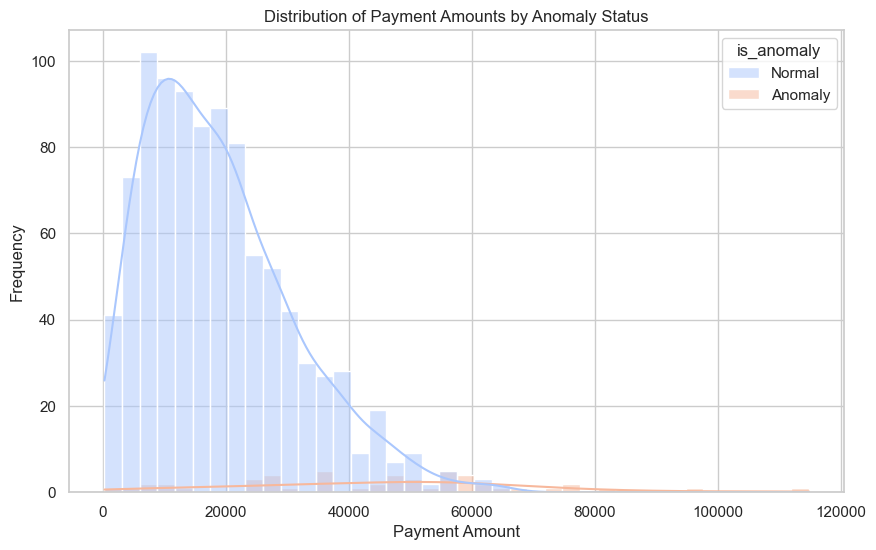

In [19]:
# This shows whether anomalies tend to occur in high or low spending.
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(data=data, x="amount", hue="is_anomaly", bins=40, kde=True, palette="coolwarm")
plt.title("Distribution of Payment Amounts by Anomaly Status")
plt.xlabel("Payment Amount")
plt.ylabel("Frequency")
plt.show()

# Scatter plot: Amount vs. Day of Week

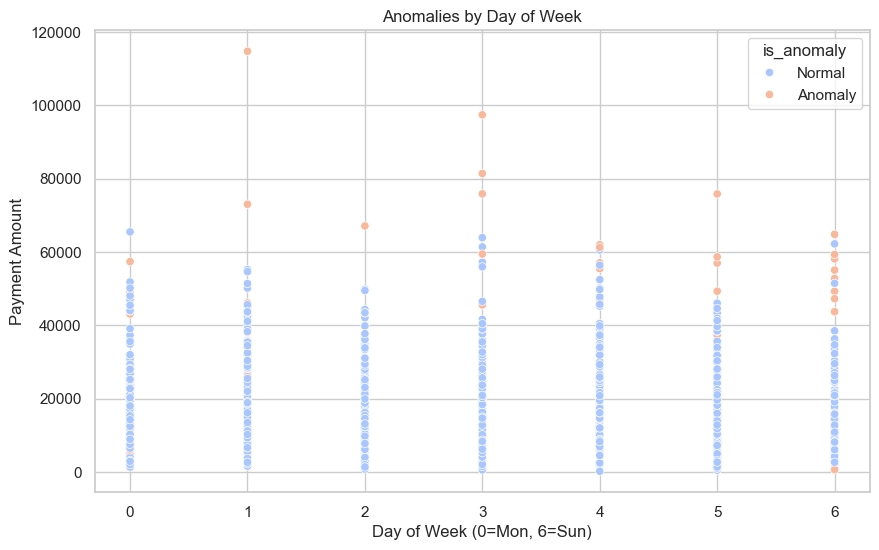

In [23]:
# Let’s check if anomalies are happening more on weekends or specific weekdays.
#data.columns
data["month"] = data_encoded["month"]
data["day_of_week"] = data_encoded["day_of_week"]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x="day_of_week", y="amount", hue="is_anomaly", palette="coolwarm")
plt.title("Anomalies by Day of Week")
plt.xlabel("Day of Week (0=Mon, 6=Sun)")
plt.ylabel("Payment Amount")
plt.show()

# Boxplot by Agency
### Check if certain departments tend to have more anomalies.

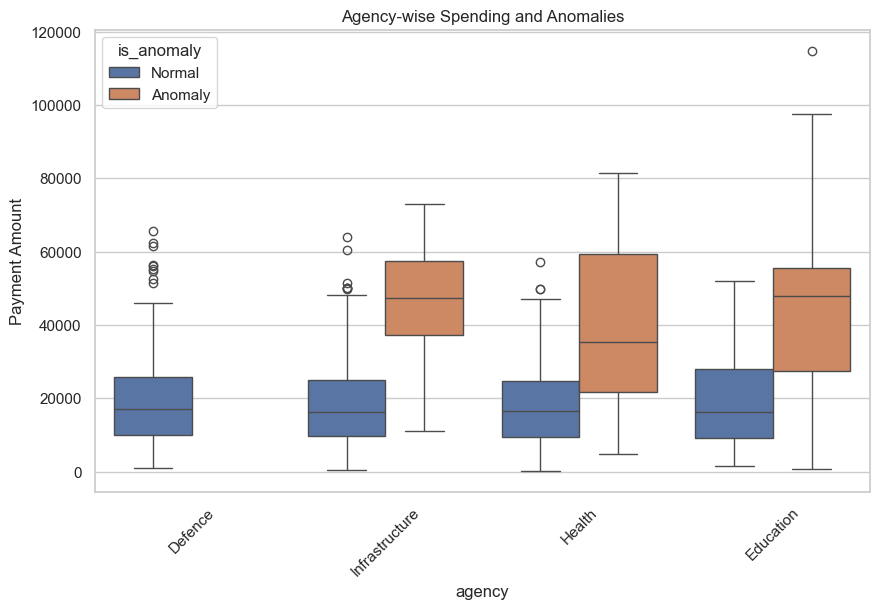

In [24]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x="agency", y="amount", hue="is_anomaly")
plt.title("Agency-wise Spending and Anomalies")
plt.ylabel("Payment Amount")
plt.xticks(rotation=45)
plt.show()

# Import SHAP and prepare the explainer

In [26]:
data_encoded.dtypes

amount                       float64
agency_Education                bool
agency_Health                   bool
agency_Infrastructure           bool
recipient_type_Individual       bool
recipient_type_Non-profit       bool
month                          int32
day_of_week                    int32
dtype: object

In [27]:
# Convert all columns to float64 (including bools and ints)
data_encoded = data_encoded.astype("float64")

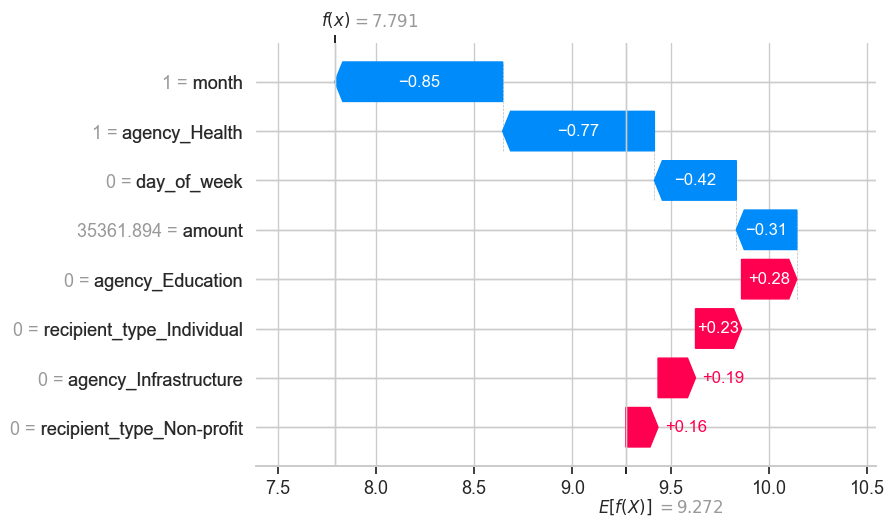

In [28]:
import shap

explainer = shap.Explainer(model, data_encoded)
shap_values = explainer(data_encoded)

# Pick an anomaly and explain it
anomaly_index = data[data["is_anomaly"] == "Anomaly"].index[0]
shap.plots.waterfall(shap_values[anomaly_index])

# Global summary of feature importance
### To understand which features contribute most to anomalies overall

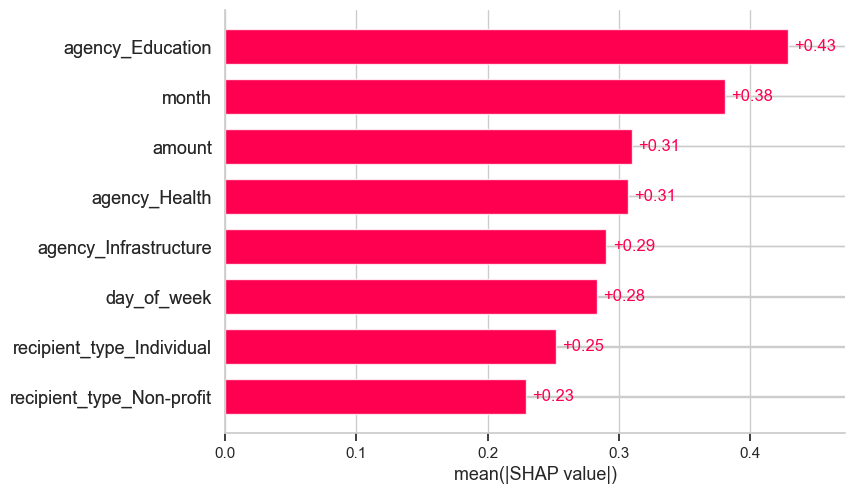

In [29]:
shap.plots.bar(shap_values)

# Export Anomalies to .csv
### This will extract all rows labeled as “Anomaly” and save them to a clean CSV file.

In [30]:
# Filter for anomalies
anomalies = data[data["is_anomaly"] == "Anomaly"]

# Export to CSV
anomalies.to_csv("anomalies_detected.csv", index=False)

print(f"{len(anomalies)} anomalies exported to 'anomalies_detected.csv'")

50 anomalies exported to 'anomalies_detected.csv'


In [31]:
# To sort by the most suspicious transactions
anomalies.sort_values("anomaly_score").head(10)

,agency,recipient_type,amount,anomaly_score,is_anomaly,month,day_of_week
745,Education,Non-profit,114792.358354,-0.083180,Anomaly,1,1
234,Infrastructure,Non-profit,73066.114108,-0.043449,Anomaly,8,1
645,Health,Individual,64853.333990,-0.039299,Anomaly,10,6
380,Infrastructure,Non-profit,48962.995827,-0.039004,Anomaly,1,0
708,Infrastructure,Non-profit,43766.472061,-0.034762,Anomaly,12,6
96,Education,Individual,97471.330379,-0.034620,Anomaly,4,3
379,Health,Individual,49309.374015,-0.033335,Anomaly,1,6
278,Health,Individual,81459.697510,-0.033020,Anomaly,10,3
189,Education,Individual,75878.793734,-0.032952,Anomaly,7,5
27,Education,Non-profit,55507.151886,-0.028029,Anomaly,1,4
